<a href="https://colab.research.google.com/github/yasinsoylu1997/NLP-PROJELER-TOPLU/blob/main/nlp_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
import re
from sklearn.model_selection import train_test_split 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk

from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [2]:
dataset = pd.read_csv('sample.csv')

In [3]:
dataset

,yildizSayisi,yorum,yorumLike
0,1,İlk ürünüm sorunsuz geldi lakin bunda prize ta...,0
1,1,Ürünü teslim aldığım günün ertesi iade için ka...,7
2,1,kesinlikle beğenmedim kullanmaya başladıktan 1...,2
3,1,Merhaba ürün elime ulaştı ama ürün bir çalışıy...,1
4,1,kargo hızlı o konuda haksızlık yapamam ama ürü...,2
...,...,...,...
49995,5,Çok güzel çok beğendim tafsiye ederim,0
49996,5,Vallahi çok işime yaradı. Aylarda öyle boşuna ...,0
49997,5,"olması gerektigi gibi , kenarda hazırda beklem...",0
49998,5,arçelik bulaşık makinesi için aldım servis olm...,0


In [4]:
dataset.dropna()

,yildizSayisi,yorum,yorumLike
0,1,İlk ürünüm sorunsuz geldi lakin bunda prize ta...,0
1,1,Ürünü teslim aldığım günün ertesi iade için ka...,7
2,1,kesinlikle beğenmedim kullanmaya başladıktan 1...,2
3,1,Merhaba ürün elime ulaştı ama ürün bir çalışıy...,1
4,1,kargo hızlı o konuda haksızlık yapamam ama ürü...,2
...,...,...,...
49995,5,Çok güzel çok beğendim tafsiye ederim,0
49996,5,Vallahi çok işime yaradı. Aylarda öyle boşuna ...,0
49997,5,"olması gerektigi gibi , kenarda hazırda beklem...",0
49998,5,arçelik bulaşık makinesi için aldım servis olm...,0


In [5]:
dataset["yildizSayisi"] = dataset.yildizSayisi.astype(float)


In [6]:
def sentiments(df):
  if df['yildizSayisi'] > 3.9:
    return 'Positive'
  elif df['yildizSayisi'] <= 3.0:
    return 'Negative'
dataset['sentiment'] = dataset.apply(sentiments, axis=1)

In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yildizSayisi  50000 non-null  float64
 1   yorum         50000 non-null  object 
 2   yorumLike     50000 non-null  int64  
 3   sentiment     50000 non-null  object 
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [8]:
dataset

,yildizSayisi,yorum,yorumLike,sentiment
0,1.0,İlk ürünüm sorunsuz geldi lakin bunda prize ta...,0,Negative
1,1.0,Ürünü teslim aldığım günün ertesi iade için ka...,7,Negative
2,1.0,kesinlikle beğenmedim kullanmaya başladıktan 1...,2,Negative
3,1.0,Merhaba ürün elime ulaştı ama ürün bir çalışıy...,1,Negative
4,1.0,kargo hızlı o konuda haksızlık yapamam ama ürü...,2,Negative
...,...,...,...,...
49995,5.0,Çok güzel çok beğendim tafsiye ederim,0,Positive
49996,5.0,Vallahi çok işime yaradı. Aylarda öyle boşuna ...,0,Positive
49997,5.0,"olması gerektigi gibi , kenarda hazırda beklem...",0,Positive
49998,5.0,arçelik bulaşık makinesi için aldım servis olm...,0,Positive


In [9]:
dataset['yorum'] = dataset['yorum'].apply(lambda x: x.lower())

In [10]:
print(dataset[ dataset['sentiment'] == 'Positive'].size)
print(dataset[ dataset['sentiment'] == 'Negative'].size)

80000
120000


In [11]:
data_pos = dataset[ dataset['sentiment'] == 'Positive']
data_pos = dataset['yorum']
data_neg = dataset[ dataset['sentiment'] == 'Negative']
data_neg = dataset['yorum']

In [12]:
def wordcloud_draw(dataset, color = 'black'):
    words = ' '.join(dataset)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [13]:
print("Positive words")
#wordcloud_draw(data_pos,'white')

Positive words


In [14]:
print("Negative words")
#wordcloud_draw(data_neg)

Negative words


In [15]:
dataset

,yildizSayisi,yorum,yorumLike,sentiment
0,1.0,i̇lk ürünüm sorunsuz geldi lakin bunda prize t...,0,Negative
1,1.0,ürünü teslim aldığım günün ertesi iade için ka...,7,Negative
2,1.0,kesinlikle beğenmedim kullanmaya başladıktan 1...,2,Negative
3,1.0,merhaba ürün elime ulaştı ama ürün bir çalışıy...,1,Negative
4,1.0,kargo hızlı o konuda haksızlık yapamam ama ürü...,2,Negative
...,...,...,...,...
49995,5.0,çok güzel çok beğendim tafsiye ederim,0,Positive
49996,5.0,vallahi çok işime yaradı. aylarda öyle boşuna ...,0,Positive
49997,5.0,"olması gerektigi gibi , kenarda hazırda beklem...",0,Positive
49998,5.0,arçelik bulaşık makinesi için aldım servis olm...,0,Positive


In [16]:
data = dataset[['yorum','sentiment']]
target = dataset['sentiment'].values

In [17]:
data

,yorum,sentiment
0,i̇lk ürünüm sorunsuz geldi lakin bunda prize t...,Negative
1,ürünü teslim aldığım günün ertesi iade için ka...,Negative
2,kesinlikle beğenmedim kullanmaya başladıktan 1...,Negative
3,merhaba ürün elime ulaştı ama ürün bir çalışıy...,Negative
4,kargo hızlı o konuda haksızlık yapamam ama ürü...,Negative
...,...,...
49995,çok güzel çok beğendim tafsiye ederim,Positive
49996,vallahi çok işime yaradı. aylarda öyle boşuna ...,Positive
49997,"olması gerektigi gibi , kenarda hazırda beklem...",Positive
49998,arçelik bulaşık makinesi için aldım servis olm...,Positive


In [18]:
data['yorum'] = data['yorum'].apply(lambda x: x.lower())
data['yorum'] = data['yorum'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['yorum'].values)
X = tokenizer.texts_to_sequences(data['yorum'].values)
X = pad_sequences(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


40000
60000


In [19]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [20]:
cutoff = int(len(data) * 0.80)
x_train, x_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

In [21]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [22]:
tokenizer.fit_on_texts(data)
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [23]:
tokenizer.fit_on_texts(data)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [24]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [25]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

1

In [26]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)



In [27]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [28]:
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [29]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [30]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [31]:
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout , LSTM, SpatialDropout1D
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import  RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses


In [38]:
max_len=177

model = Sequential()
embedding_size = 50

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_len,
                    name='embedding_layer'))

model.add(GRU(units=16, return_sequences=True))
model.add(GRU(units=8, return_sequences=True))
model.add(GRU(units=4))
model.add(Dense(2, activation='sigmoid'))

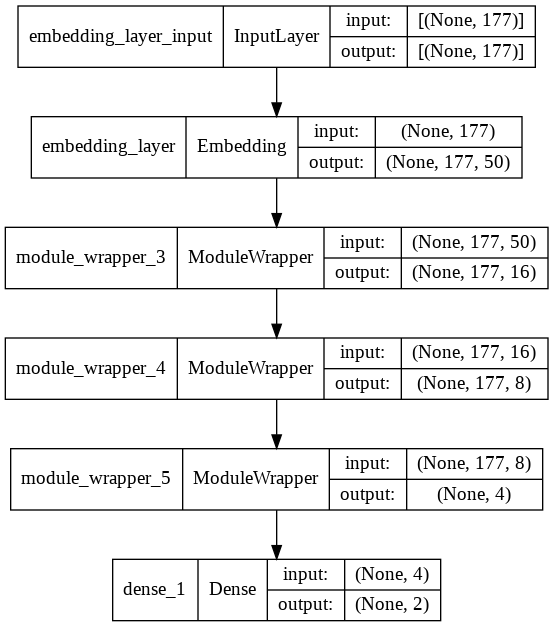

In [39]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Precision(), Recall()])

In [41]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(35000, 177) (35000, 2)
(15000, 177) (15000, 2)


In [42]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [43]:
history=model.fit(X_train, Y_train, epochs=10, batch_size=512,validation_split=0.1,callbacks=[callback])

Epoch 1/10
62/62 [==============================] - 48s 658ms/step - loss: 0.6574 - accuracy: 0.6358 - precision_1: 0.6294 - recall_1: 0.6365 - val_loss: 0.5819 - val_accuracy: 0.7734 - val_precision_1: 0.7534 - val_recall_1: 0.7986
Epoch 2/10
62/62 [==============================] - 40s 645ms/step - loss: 0.5328 - accuracy: 0.8044 - precision_1: 0.7897 - recall_1: 0.8277 - val_loss: 0.4987 - val_accuracy: 0.8100 - val_precision_1: 0.8023 - val_recall_1: 0.8266
Epoch 3/10
62/62 [==============================] - 40s 643ms/step - loss: 0.4699 - accuracy: 0.8327 - precision_1: 0.8241 - recall_1: 0.8454 - val_loss: 0.4660 - val_accuracy: 0.8257 - val_precision_1: 0.8173 - val_recall_1: 0.8360
Epoch 4/10
62/62 [==============================] - 40s 646ms/step - loss: 0.4349 - accuracy: 0.8468 - precision_1: 0.8407 - recall_1: 0.8546 - val_loss: 0.4434 - val_accuracy: 0.8320 - val_precision_1: 0.8270 - val_recall_1: 0.8371
Epoch 5/10
62/62 [==============================] - 40s 646ms/step -

In [44]:
 score = model.evaluate(X_test, Y_test,batch_size=512)


30/30 [==============================] - 3s 111ms/step - loss: 0.4216 - accuracy: 0.8306 - precision_1: 0.8310 - recall_1: 0.8299


In [45]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.42161494493484497
Test accuracy: 0.8306000232696533
